# LME銅先物タームストラクチャー・ボラティリティ分析

## 分析目的
このノートブックは、LME銅先物の全36限月にわたるボラティリティ特性とタームストラクチャーを分析し、以下を理解します：
1. **限月別ボラティリティ**: 各契約のリスク特性の違い
2. **ボラティリティ・ターム構造**: 満期とボラティリティの関係
3. **時変ボラティリティ**: 市場状況による変化パターン
4. **ボラティリティクラスタリング**: 高ボラティリティ期間の特定
5. **流動性との関係**: 出来高とボラティリティの相関

## 主要概念と解釈
- **実現ボラティリティ**: 過去の価格変動から計算される実際のボラティリティ
- **年率ボラティリティ**: 比較可能な形式に標準化されたボラティリティ
- **ボラティリティ・ターム構造**: 満期とボラティリティの関係曲線
- **ボラティリティクラスタリング**: 高ボラティリティが連続して発生する現象
- **サムエルソン効果**: 満期に近づくにつれてボラティリティが増加する現象

In [1]:
# より軽量なインポート方法でpandasの読み込み問題を回避
try:
    import pandas as pd
    print("✓ pandas successfully imported")
except Exception as e:
    print(f"✗ pandas import failed: {e}")
    print("Trying alternative import...")
    import sys
    sys.exit(1)

try:
    import numpy as np
    import matplotlib.pyplot as plt
    print("✓ numpy and matplotlib imported")
except Exception as e:
    print(f"✗ numpy/matplotlib import failed: {e}")

try:
    import seaborn as sns
    print("✓ seaborn imported")
except Exception as e:
    print("✗ seaborn not available, using matplotlib only")
    sns = None

try:
    from sqlalchemy import create_engine
    print("✓ sqlalchemy imported")
except Exception as e:
    print(f"✗ sqlalchemy import failed: {e}")

import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
from scipy import stats

warnings.filterwarnings('ignore')
load_dotenv()

# データベース設定
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

# Create connection string
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

# スタイル設定
plt.style.use('default')
if sns:
    sns.set_palette("viridis")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = [12, 8]

print("✓ All basic libraries loaded successfully")
print("Ready for volatility analysis")

✓ pandas successfully imported
✓ numpy and matplotlib imported
✓ seaborn imported
✓ sqlalchemy imported
✓ All basic libraries loaded successfully
Ready for volatility analysis


## データ読み込みと準備

In [2]:
def load_all_futures_data():
    """全36限月のLME銅先物データを読み込み"""
    try:
        engine = create_engine(connection_string)
        
        query = """
        SELECT 
            trade_date,
            contract_month,
            ric,
            close_price,
            high_price,
            low_price,
            open_price,
            volume
        FROM lme_copper_futures
        WHERE close_price IS NOT NULL
        ORDER BY trade_date, contract_month
        """
        
        df = pd.read_sql_query(query, engine)
        engine.dispose()
        
        # データ前処理
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        
        # 価格分析用ピボットテーブル作成
        price_pivot = df.pivot(index='trade_date', columns='contract_month', values='close_price')
        volume_pivot = df.pivot(index='trade_date', columns='contract_month', values='volume')
        
        # 前方補完で欠損値を埋める
        price_pivot = price_pivot.ffill()
        volume_pivot = volume_pivot.ffill()
        
        print(f"データ読み込み完了: {len(df):,}件のレコード")
        print(f"期間: {df['trade_date'].min()} ～ {df['trade_date'].max()}")
        print(f"価格マトリックス形状: {price_pivot.shape}")
        print(f"利用可能な契約: {sorted(price_pivot.columns.tolist())}")
        
        return df, price_pivot, volume_pivot
    
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        return None, None, None

# データ読み込み
df, price_matrix, volume_matrix = load_all_futures_data()

if df is not None:
    print(f"\nデータ概要:")
    print(f"- 総レコード数: {len(df):,}")
    print(f"- 利用可能限月数: {len(price_matrix.columns)}")
    print(f"- 期間: {len(price_matrix)} 取引日")
    print(f"- 最大限月: {price_matrix.columns.max()}ヶ月")

データ読み込み完了: 45,407件のレコード
期間: 2020-07-06 00:00:00 ～ 2025-07-04 00:00:00
価格マトリックス形状: (1263, 36)
利用可能な契約: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

データ概要:
- 総レコード数: 45,407
- 利用可能限月数: 36
- 期間: 1263 取引日
- 最大限月: 36ヶ月


## 1. 基本ボラティリティ計算

### 解釈ガイド:
- **日次リターン**: 対数リターンで計算（連続複利前提）
- **実現ボラティリティ**: 過去の価格変動から計算される実際のボラティリティ
- **年率換算**: 取引日数（252日）で標準化
- **ローリングボラティリティ**: 時間変化を捉える動的指標

In [3]:
def calculate_volatility_metrics(price_data):
    """各限月のボラティリティ指標を計算"""
    if price_data is None:
        return None
    
    # 日次リターン計算（対数リターン）
    returns = np.log(price_data / price_data.shift(1))
    
    # ボラティリティ指標計算
    volatility_metrics = pd.DataFrame(index=price_data.columns)
    
    for contract in price_data.columns:
        contract_returns = returns[contract].dropna()
        
        if len(contract_returns) > 30:  # 最低30日のデータが必要
            # 基本統計
            volatility_metrics.loc[contract, 'daily_vol'] = contract_returns.std()
            volatility_metrics.loc[contract, 'annual_vol'] = contract_returns.std() * np.sqrt(252)
            volatility_metrics.loc[contract, 'mean_return'] = contract_returns.mean()
            volatility_metrics.loc[contract, 'annual_return'] = contract_returns.mean() * 252
            
            # リスク調整済みリターン
            volatility_metrics.loc[contract, 'sharpe_ratio'] = (contract_returns.mean() * 252) / (contract_returns.std() * np.sqrt(252))
            
            # 分布統計
            volatility_metrics.loc[contract, 'skewness'] = stats.skew(contract_returns)
            volatility_metrics.loc[contract, 'kurtosis'] = stats.kurtosis(contract_returns)
            
            # VaR計算（5%）
            volatility_metrics.loc[contract, 'var_5pct'] = np.percentile(contract_returns, 5)
            volatility_metrics.loc[contract, 'var_1pct'] = np.percentile(contract_returns, 1)
            
            # データ品質
            volatility_metrics.loc[contract, 'data_points'] = len(contract_returns)
            volatility_metrics.loc[contract, 'data_coverage'] = len(contract_returns) / len(price_data)
    
    return volatility_metrics.round(4)

# ボラティリティ指標計算
vol_metrics = calculate_volatility_metrics(price_matrix)

if vol_metrics is not None:
    print("限月別ボラティリティ指標:")
    print("="*80)
    print(vol_metrics[['annual_vol', 'annual_return', 'sharpe_ratio', 'skewness', 'kurtosis']].head(20))
    
    print(f"\nボラティリティサマリー:")
    print(f"最低年率ボラティリティ: {vol_metrics['annual_vol'].min():.1%} (第{vol_metrics['annual_vol'].idxmin()}限月)")
    print(f"最高年率ボラティリティ: {vol_metrics['annual_vol'].max():.1%} (第{vol_metrics['annual_vol'].idxmax()}限月)")
    print(f"平均年率ボラティリティ: {vol_metrics['annual_vol'].mean():.1%}")
    print(f"ボラティリティ範囲: {(vol_metrics['annual_vol'].max() - vol_metrics['annual_vol'].min()):.1%}")

限月別ボラティリティ指標:
                annual_vol  annual_return  sharpe_ratio  skewness  kurtosis
contract_month                                                             
1                   0.2200         0.0960        0.4364   -0.3398    3.5615
2                   0.2111         0.0954        0.4516   -0.2355    1.5071
3                   0.2093         0.0951        0.4542   -0.2430    1.5418
4                   0.2078         0.0951        0.4574   -0.2471    1.5875
5                   0.2068         0.0951        0.4600   -0.2441    1.6298
6                   0.2056         0.0952        0.4628   -0.2460    1.6311
7                   0.2044         0.0952        0.4655   -0.2471    1.6505
8                   0.2035         0.0951        0.4675   -0.2442    1.6502
9                   0.2025         0.0951        0.4694   -0.2385    1.6726
10                  0.2017         0.0950        0.4710   -0.2343    1.6588
11                  0.2009         0.0949        0.4725   -0.2317    1.660

## 2. ボラティリティ・ターム構造分析

### 解釈ガイド:
- **サムエルソン効果**: 満期が近いほどボラティリティが高い傾向
- **流動性効果**: 取引が活発な契約ほど価格発見が効率的
- **情報効果**: 近月は現物市場の影響をより強く受ける
- **平坦化**: 遠月では投機的要因が減少

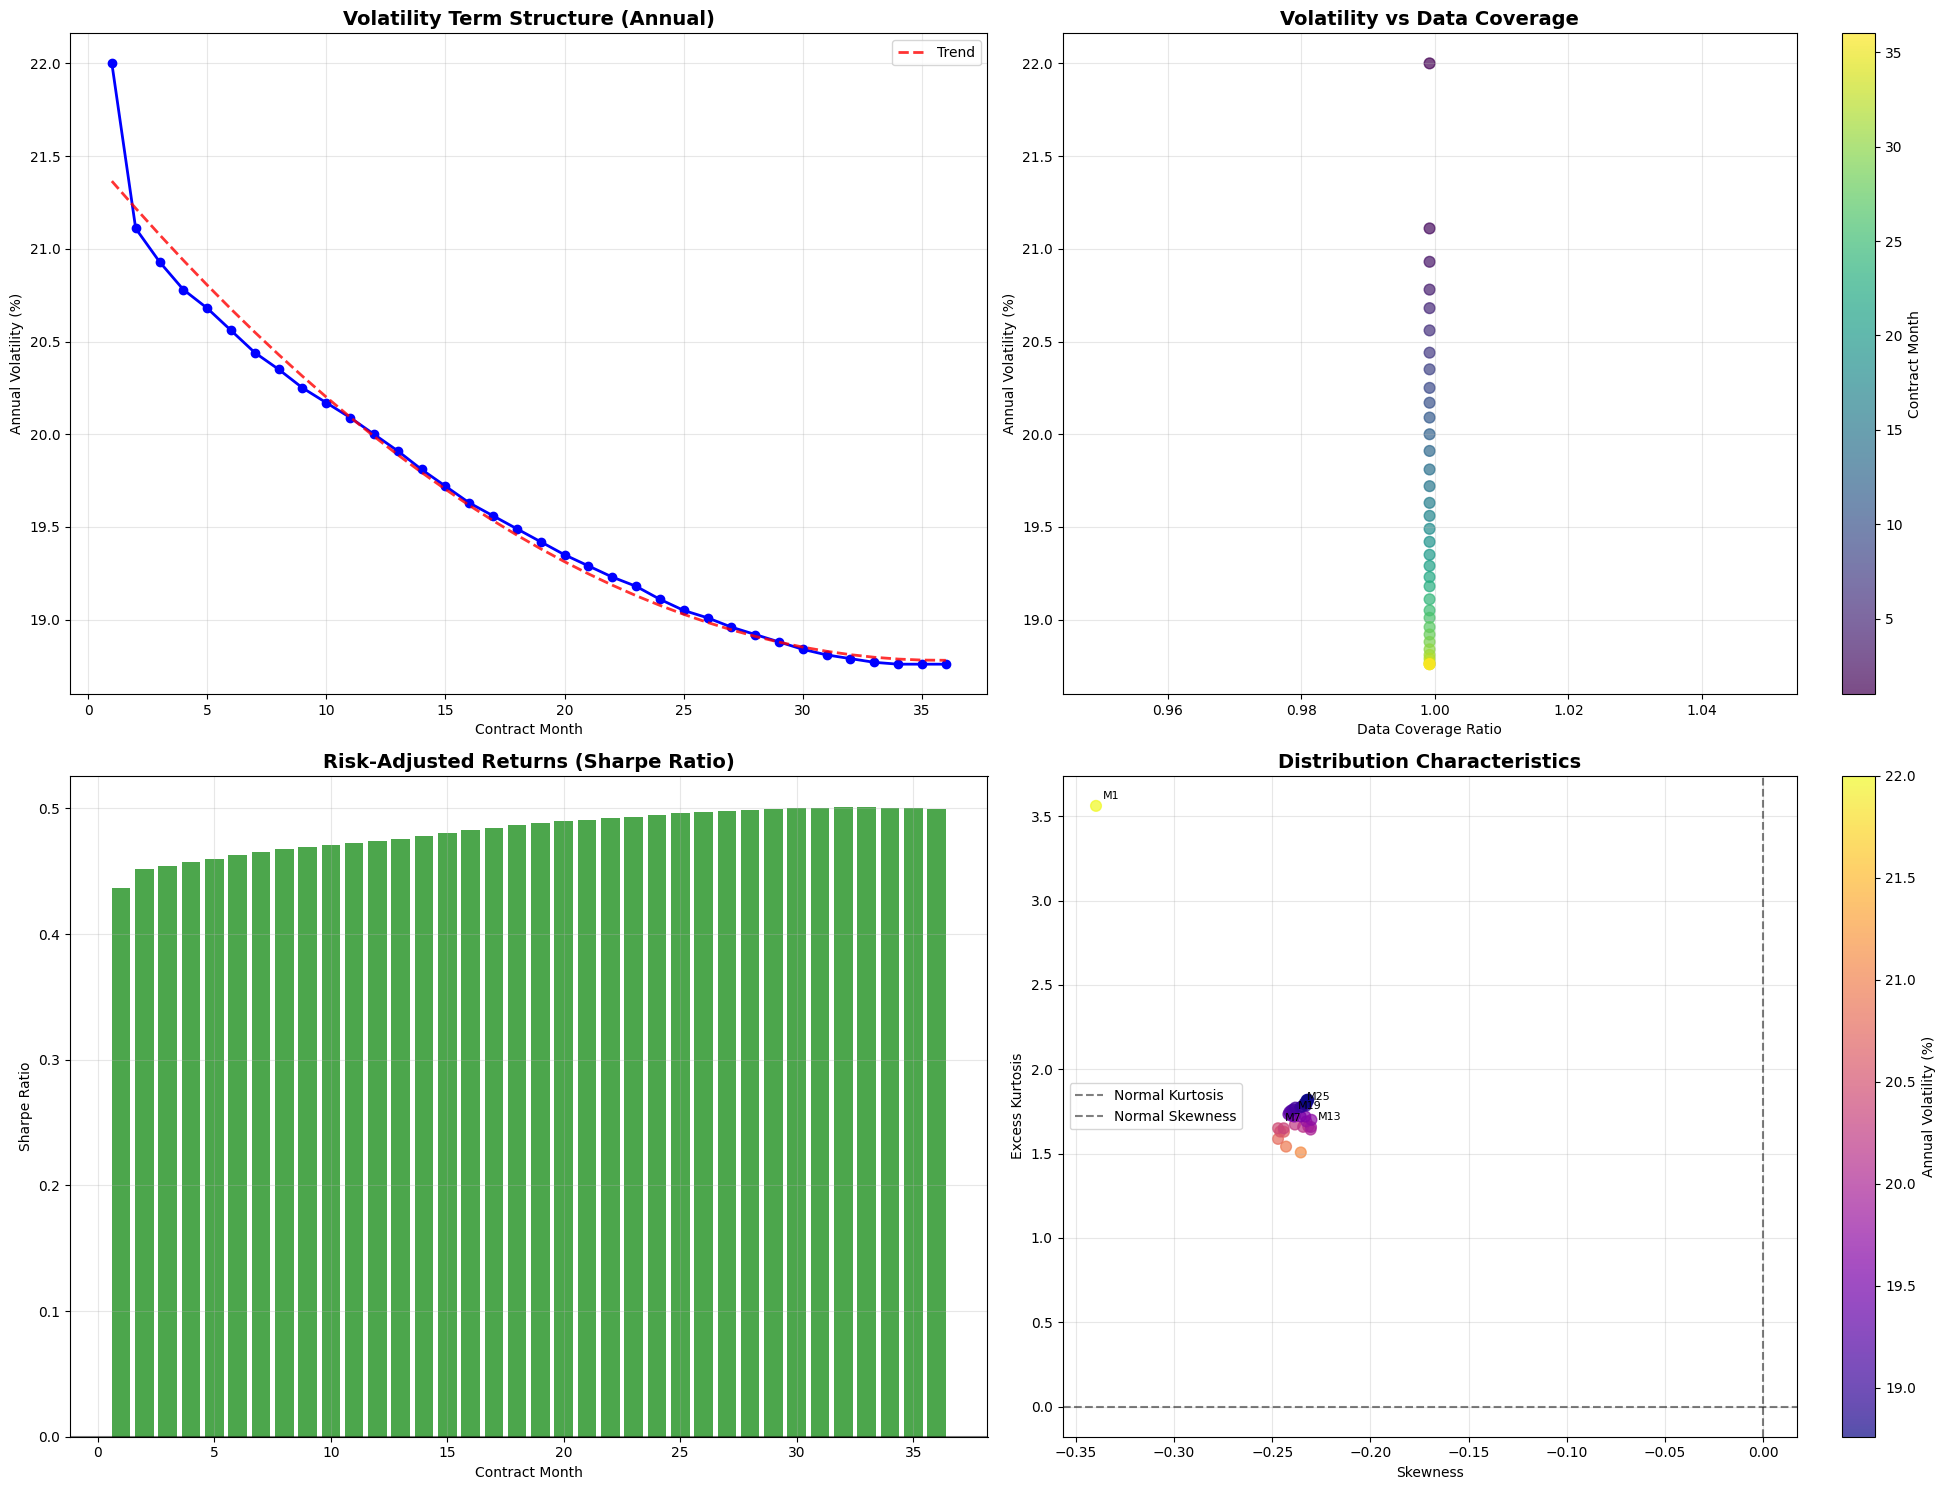

In [4]:
# ボラティリティ・ターム構造可視化
if vol_metrics is not None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 年率ボラティリティ・ターム構造
    months = vol_metrics.index[:36]  # 前36限月
    annual_vols = vol_metrics.loc[months, 'annual_vol'] * 100  # パーセント変換
    
    ax1.plot(months, annual_vols, marker='o', linewidth=2, markersize=6, color='blue')
    ax1.set_title('Volatility Term Structure (Annual)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Contract Month')
    ax1.set_ylabel('Annual Volatility (%)')
    ax1.grid(True, alpha=0.3)
    
    # トレンドライン追加（エラーハンドリング付き）
    try:
        if len(annual_vols) >= 3:  # 最低3点必要
            z = np.polyfit(months, annual_vols, 2)  # 2次多項式フィット
            p = np.poly1d(z)
            ax1.plot(months, p(months), "r--", alpha=0.8, linewidth=2, label='Trend')
            ax1.legend()
    except (np.linalg.LinAlgError, np.RankWarning):
        print("Warning: Could not fit trend line for volatility term structure")
    
    # 2. ボラティリティ vs データ品質
    coverage = vol_metrics.loc[months, 'data_coverage']
    scatter = ax2.scatter(coverage, annual_vols, c=months, cmap='viridis', s=60, alpha=0.7)
    ax2.set_title('Volatility vs Data Coverage', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Data Coverage Ratio')
    ax2.set_ylabel('Annual Volatility (%)')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Contract Month')
    
    # 3. リスク調整済みリターン（シャープレシオ）
    sharpe_ratios = vol_metrics.loc[months, 'sharpe_ratio']
    # NaN値を除去
    valid_sharpe = sharpe_ratios.dropna()
    if len(valid_sharpe) > 0:
        colors = ['green' if x > 0 else 'red' for x in valid_sharpe]
        bars = ax3.bar(valid_sharpe.index, valid_sharpe.values, color=colors, alpha=0.7)
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax3.set_title('Risk-Adjusted Returns (Sharpe Ratio)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Contract Month')
        ax3.set_ylabel('Sharpe Ratio')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No valid Sharpe ratio data', 
                transform=ax3.transAxes, ha='center', va='center')
    
    # 4. 分布特性（歪度 vs 尖度）
    skewness = vol_metrics.loc[months, 'skewness'].dropna()
    kurtosis = vol_metrics.loc[months, 'kurtosis'].dropna()
    
    if len(skewness) > 0 and len(kurtosis) > 0:
        # 共通インデックスを取得
        common_index = skewness.index.intersection(kurtosis.index)
        if len(common_index) > 0:
            skew_common = skewness.loc[common_index]
            kurt_common = kurtosis.loc[common_index]
            vol_common = annual_vols.loc[common_index]
            
            scatter2 = ax4.scatter(skew_common, kurt_common, c=vol_common, cmap='plasma', s=60, alpha=0.7)
            ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Normal Kurtosis')
            ax4.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Normal Skewness')
            ax4.set_title('Distribution Characteristics', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Skewness')
            ax4.set_ylabel('Excess Kurtosis')
            ax4.grid(True, alpha=0.3)
            ax4.legend()
            plt.colorbar(scatter2, ax=ax4, label='Annual Volatility (%)')
            
            # 限月ラベル追加（一部のみ）
            label_indices = common_index[::6] if len(common_index) > 6 else common_index  # 6ヶ月おきまたは全部
            for month in label_indices[:5]:  # 最大5個のラベル
                if month in skew_common.index and month in kurt_common.index:
                    ax4.annotate(f'M{month}', (skew_common[month], kurt_common[month]), 
                                xytext=(5, 5), textcoords='offset points', fontsize=8)
        else:
            ax4.text(0.5, 0.5, 'No valid distribution data', 
                    transform=ax4.transAxes, ha='center', va='center')
    else:
        ax4.text(0.5, 0.5, 'Insufficient data for distribution analysis', 
                transform=ax4.transAxes, ha='center', va='center')
    
    plt.tight_layout()
    plt.savefig('../generated_images/volatility_term_structure.png', dpi=300, bbox_inches='tight')
    plt.show()

## 3. 時変ボラティリティ分析

### 解釈ガイド:
- **ボラティリティクラスタリング**: 高ボラティリティ期間の連続性
- **構造変化**: 市場環境変化によるボラティリティレベルの変化
- **季節性**: 年間を通じたボラティリティパターン
- **ボラティリティスピルオーバー**: 限月間でのボラティリティ波及効果

In [5]:
def calculate_rolling_volatility(price_data, windows=[30, 60, 252]):
    """ローリングボラティリティを計算"""
    returns = np.log(price_data / price_data.shift(1))
    
    rolling_vol = {}
    for window in windows:
        rolling_vol[f'{window}d'] = returns.rolling(window).std() * np.sqrt(252)
    
    return rolling_vol

# 主要限月のローリングボラティリティ計算
key_contracts = [1, 3, 6, 12, 24, 36] if 36 in price_matrix.columns else [1, 3, 6, 12]
available_contracts = [c for c in key_contracts if c in price_matrix.columns]

rolling_vols = {}
for contract in available_contracts:
    if contract in price_matrix.columns:
        contract_prices = price_matrix[contract].dropna()
        if len(contract_prices) > 252:  # 最低1年のデータが必要
            returns = np.log(contract_prices / contract_prices.shift(1))
            rolling_vols[f'M{contract}'] = {
                'returns': returns,
                'vol_30d': returns.rolling(30).std() * np.sqrt(252),
                'vol_60d': returns.rolling(60).std() * np.sqrt(252),
                'vol_252d': returns.rolling(252).std() * np.sqrt(252)
            }

print(f"ローリングボラティリティ計算完了: {len(rolling_vols)}契約")
for contract in rolling_vols.keys():
    recent_vol = rolling_vols[contract]['vol_30d'].iloc[-1] if not rolling_vols[contract]['vol_30d'].empty else None
    if recent_vol:
        print(f"{contract}: 最新30日ボラティリティ {recent_vol:.1%}")

ローリングボラティリティ計算完了: 6契約
M1: 最新30日ボラティリティ 13.2%
M3: 最新30日ボラティリティ 11.6%
M6: 最新30日ボラティリティ 10.9%
M12: 最新30日ボラティリティ 10.3%
M24: 最新30日ボラティリティ 9.9%
M36: 最新30日ボラティリティ 9.8%


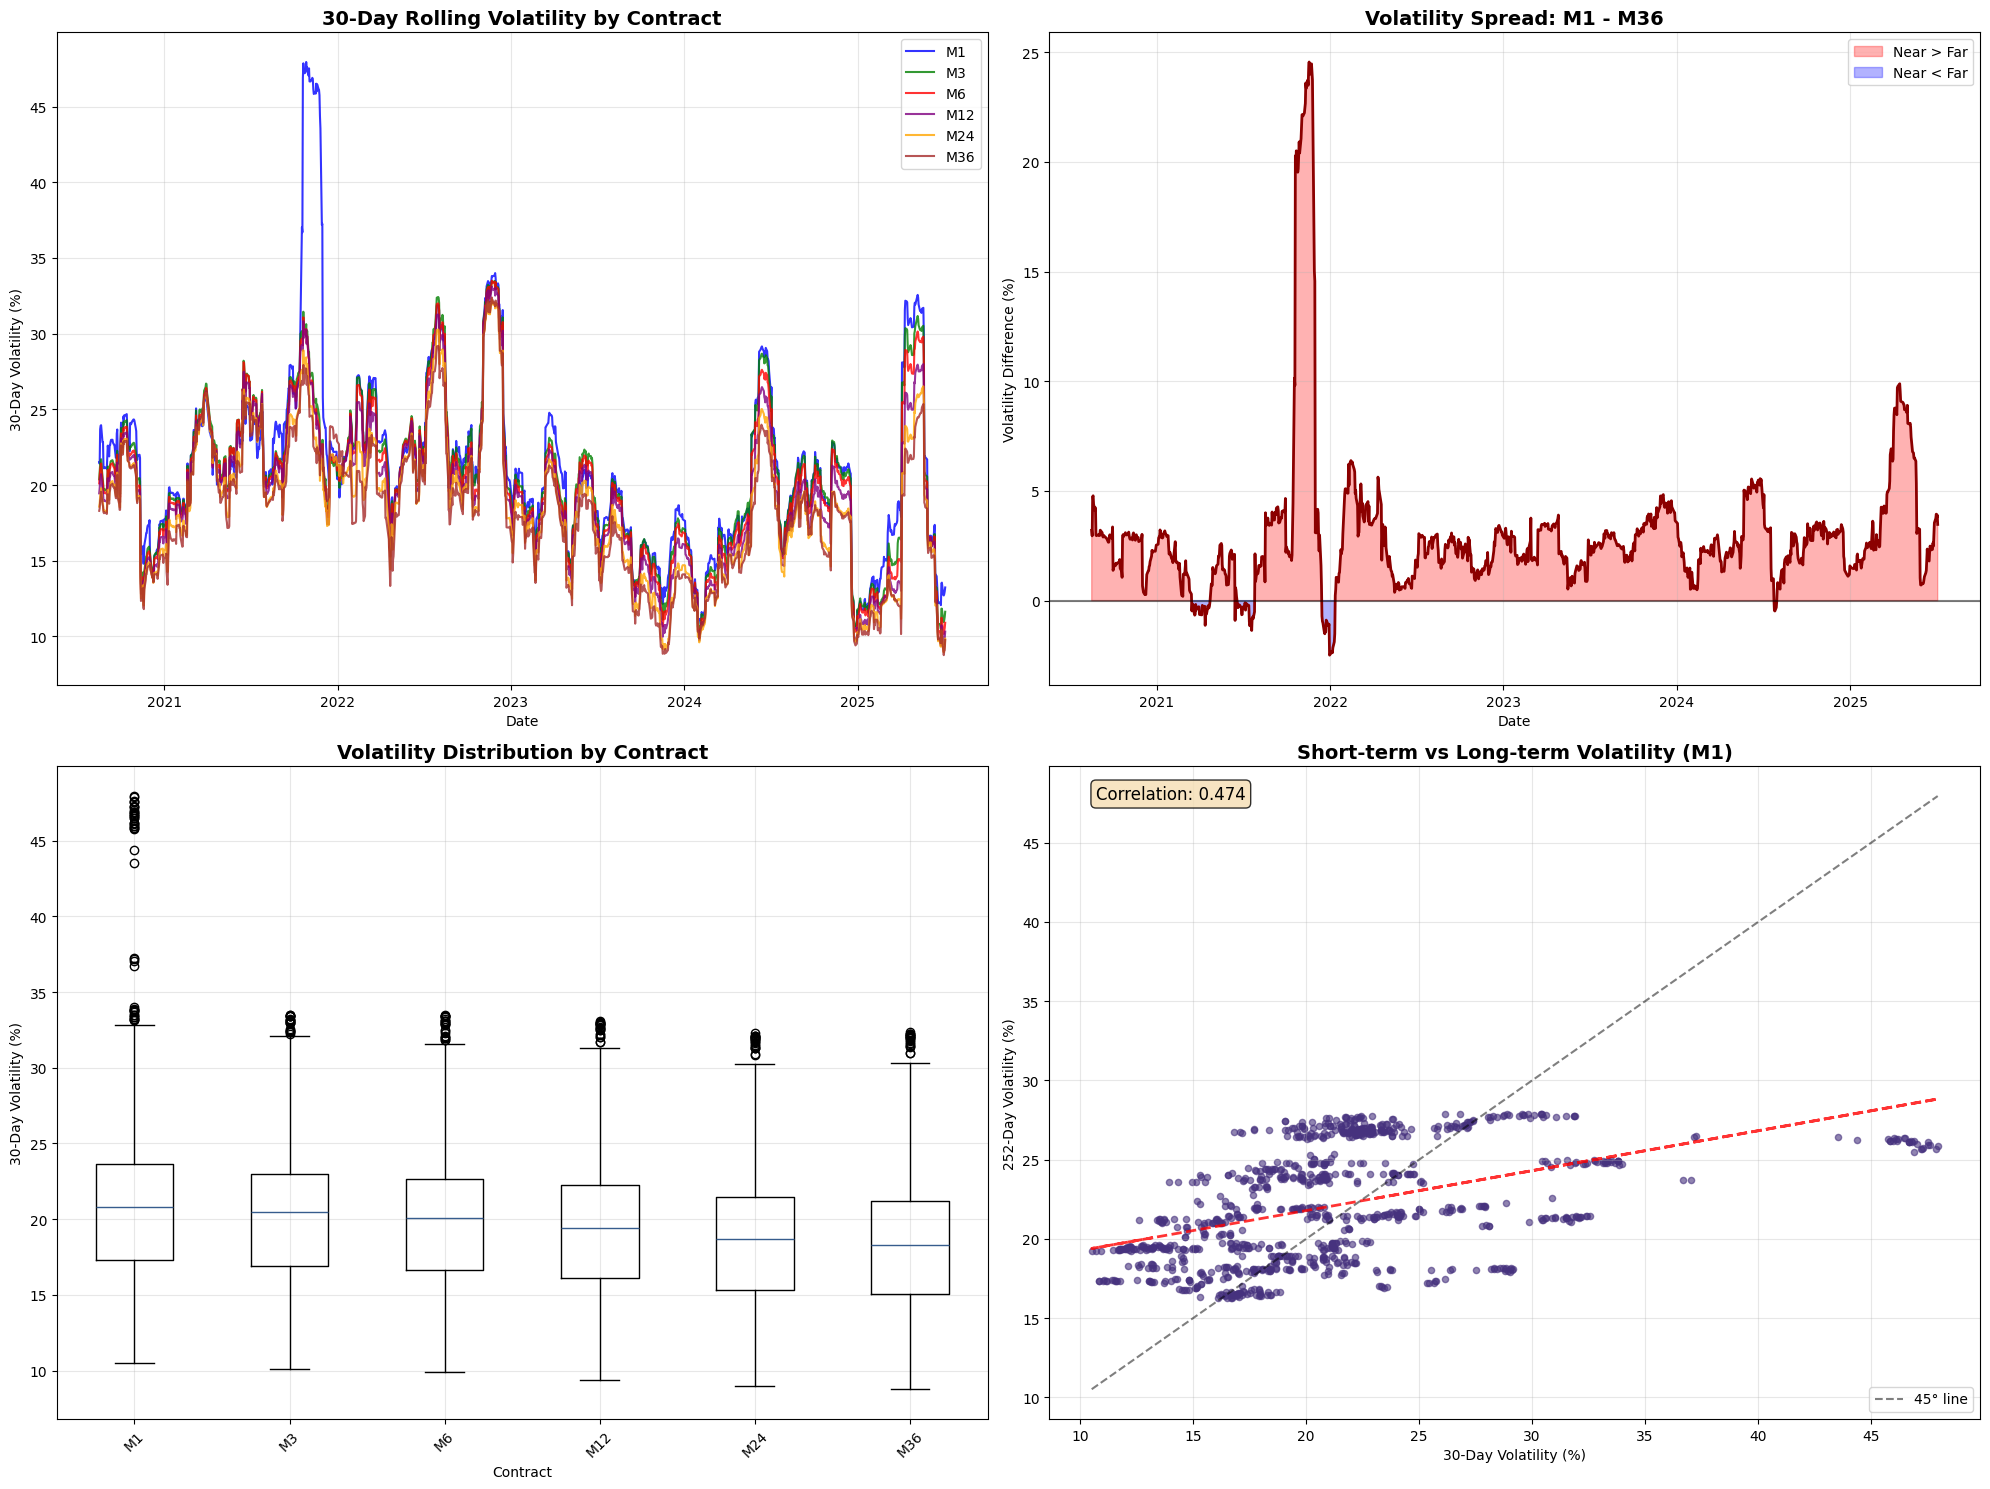

In [6]:
# 時変ボラティリティ可視化
if rolling_vols:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 主要契約の30日ローリングボラティリティ
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
    for i, (contract, data) in enumerate(rolling_vols.items()):
        if i < len(colors):
            vol_data = data['vol_30d'] * 100  # パーセント変換
            ax1.plot(vol_data.index, vol_data, label=contract, 
                    color=colors[i], linewidth=1.5, alpha=0.8)
    
    ax1.set_title('30-Day Rolling Volatility by Contract', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('30-Day Volatility (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. ボラティリティ差分（近月 vs 遠月）
    if 'M1' in rolling_vols and len(rolling_vols) > 1:
        near_vol = rolling_vols['M1']['vol_30d']
        far_contract = list(rolling_vols.keys())[-1]  # 最も遠い限月
        far_vol = rolling_vols[far_contract]['vol_30d']
        
        # 共通期間のデータを取得
        common_dates = near_vol.index.intersection(far_vol.index)
        if len(common_dates) > 0:
            vol_diff = (near_vol.loc[common_dates] - far_vol.loc[common_dates]) * 100
            
            ax2.plot(vol_diff.index, vol_diff, linewidth=2, color='darkred')
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            ax2.fill_between(vol_diff.index, 0, vol_diff, 
                           where=(vol_diff > 0), alpha=0.3, color='red', label='Near > Far')
            ax2.fill_between(vol_diff.index, 0, vol_diff, 
                           where=(vol_diff < 0), alpha=0.3, color='blue', label='Near < Far')
            
            ax2.set_title(f'Volatility Spread: M1 - {far_contract}', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Date')
            ax2.set_ylabel('Volatility Difference (%)')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
    
    # 3. ボラティリティ分布（契約別）
    vol_distributions = []
    contract_labels = []
    
    for contract, data in rolling_vols.items():
        vol_clean = data['vol_30d'].dropna() * 100
        if len(vol_clean) > 100:  # 十分なデータがある場合のみ
            vol_distributions.append(vol_clean)
            contract_labels.append(contract)
    
    if vol_distributions:
        ax3.boxplot(vol_distributions, labels=contract_labels)
        ax3.set_title('Volatility Distribution by Contract', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Contract')
        ax3.set_ylabel('30-Day Volatility (%)')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
    
    # 4. ボラティリティ相関（短期 vs 長期）- エラーハンドリング付き
    if 'M1' in rolling_vols:
        short_vol = rolling_vols['M1']['vol_30d']
        long_vol = rolling_vols['M1']['vol_252d']
        
        # 共通期間のデータを取得
        common_dates = short_vol.index.intersection(long_vol.index)
        if len(common_dates) > 0:
            short_common = short_vol.loc[common_dates] * 100
            long_common = long_vol.loc[common_dates] * 100
            
            # NaN値を除去
            valid_mask = ~(short_common.isna() | long_common.isna())
            short_clean = short_common[valid_mask]
            long_clean = long_common[valid_mask]
            
            if len(short_clean) > 10:  # 十分なデータがある場合のみ
                ax4.scatter(short_clean, long_clean, alpha=0.6, s=20)
                
                # 回帰線を追加（エラーハンドリング付き）
                try:
                    # データの分散を確認
                    if short_clean.std() > 1e-10 and long_clean.std() > 1e-10:
                        z = np.polyfit(short_clean, long_clean, 1)
                        p = np.poly1d(z)
                        ax4.plot(short_clean, p(short_clean), "r--", alpha=0.8, linewidth=2)
                        
                        # 相関係数を計算
                        correlation = short_clean.corr(long_clean)
                        ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                                transform=ax4.transAxes, fontsize=12, 
                                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
                    else:
                        ax4.text(0.05, 0.95, 'Insufficient data variation', 
                                transform=ax4.transAxes, fontsize=12, 
                                bbox=dict(boxstyle="round", facecolor='lightcoral', alpha=0.8))
                
                except (np.linalg.LinAlgError, np.RankWarning) as e:
                    print(f"Warning: Could not fit regression line for volatility correlation: {e}")
                    ax4.text(0.05, 0.95, 'Regression line unavailable', 
                            transform=ax4.transAxes, fontsize=12, 
                            bbox=dict(boxstyle="round", facecolor='lightcoral', alpha=0.8))
                
                ax4.set_title('Short-term vs Long-term Volatility (M1)', fontsize=14, fontweight='bold')
                ax4.set_xlabel('30-Day Volatility (%)')
                ax4.set_ylabel('252-Day Volatility (%)')
                ax4.grid(True, alpha=0.3)
                
                # 45度線を追加
                if len(short_clean) > 0 and len(long_clean) > 0:
                    min_val = min(short_clean.min(), long_clean.min())
                    max_val = max(short_clean.max(), long_clean.max())
                    ax4.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='45° line')
                    ax4.legend()
            else:
                ax4.text(0.5, 0.5, 'Insufficient data for correlation analysis', 
                        transform=ax4.transAxes, ha='center', va='center')
    
    plt.tight_layout()
    plt.savefig('../generated_images/time_varying_volatility.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. ボラティリティと出来高の関係

### 解釈ガイド:
- **出来高-ボラティリティ関係**: 通常正の相関（活発な取引=高ボラティリティ）
- **流動性プレミアム**: 低流動性契約での高ボラティリティ
- **情報取引**: 新しい情報による出来高とボラティリティの同時増加
- **市場深度**: 出来高の多い契約での価格安定性

In [7]:
def analyze_volume_volatility_relationship(price_data, volume_data):
    """出来高とボラティリティの関係を分析"""
    if price_data is None or volume_data is None:
        return None
    
    # 日次リターンとボラティリティ計算
    returns = np.log(price_data / price_data.shift(1))
    daily_vol = returns.abs()  # 絶対リターンをボラティリティ代理変数として使用
    
    # 共通の契約のみ分析
    common_contracts = price_data.columns.intersection(volume_data.columns)
    
    relationships = {}
    
    for contract in common_contracts[:12]:  # 前12限月に限定
        # データを結合
        contract_data = pd.DataFrame({
            'volume': volume_data[contract],
            'volatility': daily_vol[contract],
            'returns': returns[contract]
        }).dropna()
        
        if len(contract_data) > 100:
            # 相関計算
            vol_volume_corr = contract_data['volume'].corr(contract_data['volatility'])
            
            # 平均値計算
            avg_volume = contract_data['volume'].mean()
            avg_volatility = contract_data['volatility'].mean()
            
            # 高出来高日と低出来高日のボラティリティ比較
            high_volume_threshold = contract_data['volume'].quantile(0.8)
            low_volume_threshold = contract_data['volume'].quantile(0.2)
            
            high_vol_days = contract_data[contract_data['volume'] >= high_volume_threshold]['volatility']
            low_vol_days = contract_data[contract_data['volume'] <= low_volume_threshold]['volatility']
            
            relationships[contract] = {
                'correlation': vol_volume_corr,
                'avg_volume': avg_volume,
                'avg_volatility': avg_volatility,
                'high_vol_volatility': high_vol_days.mean() if len(high_vol_days) > 0 else np.nan,
                'low_vol_volatility': low_vol_days.mean() if len(low_vol_days) > 0 else np.nan,
                'data': contract_data
            }
    
    return relationships

# 出来高-ボラティリティ関係分析
vol_volume_analysis = analyze_volume_volatility_relationship(price_matrix, volume_matrix)

if vol_volume_analysis:
    print("出来高-ボラティリティ関係分析:")
    print("="*70)
    print(f"{'契約':<6} {'相関':<8} {'平均出来高':<12} {'平均ボラティリティ':<15} {'高出来高時Vol':<12} {'低出来高時Vol':<12}")
    print("-" * 70)
    
    for contract, metrics in vol_volume_analysis.items():
        print(f"M{contract:<5} {metrics['correlation']:<8.3f} {metrics['avg_volume']:<12.0f} "
              f"{metrics['avg_volatility']:<15.4f} {metrics['high_vol_volatility']:<12.4f} "
              f"{metrics['low_vol_volatility']:<12.4f}")
    
    # 平均相関計算
    avg_correlation = np.mean([metrics['correlation'] for metrics in vol_volume_analysis.values() 
                              if not np.isnan(metrics['correlation'])])
    print(f"\n平均出来高-ボラティリティ相関: {avg_correlation:.3f}")

出来高-ボラティリティ関係分析:
契約     相関       平均出来高        平均ボラティリティ       高出来高時Vol     低出来高時Vol    
----------------------------------------------------------------------
M1     0.073    225          0.0101          0.0112       0.0092      
M2     0.108    518          0.0101          0.0110       0.0092      
M3     0.075    467          0.0100          0.0114       0.0080      
M4     0.020    288          0.0099          0.0118       0.0095      
M5     0.040    142          0.0098          0.0098       0.0094      
M6     0.081    76           0.0098          0.0108       0.0097      
M7     0.038    52           0.0097          0.0102       0.0105      
M8     -0.007   35           0.0097          0.0101       0.0096      
M9     0.031    45           0.0096          0.0101       0.0100      
M10    0.019    51           0.0095          0.0106       0.0094      
M11    0.000    43           0.0095          0.0096       0.0091      
M12    -0.028   47           0.0095          0.0097       0.

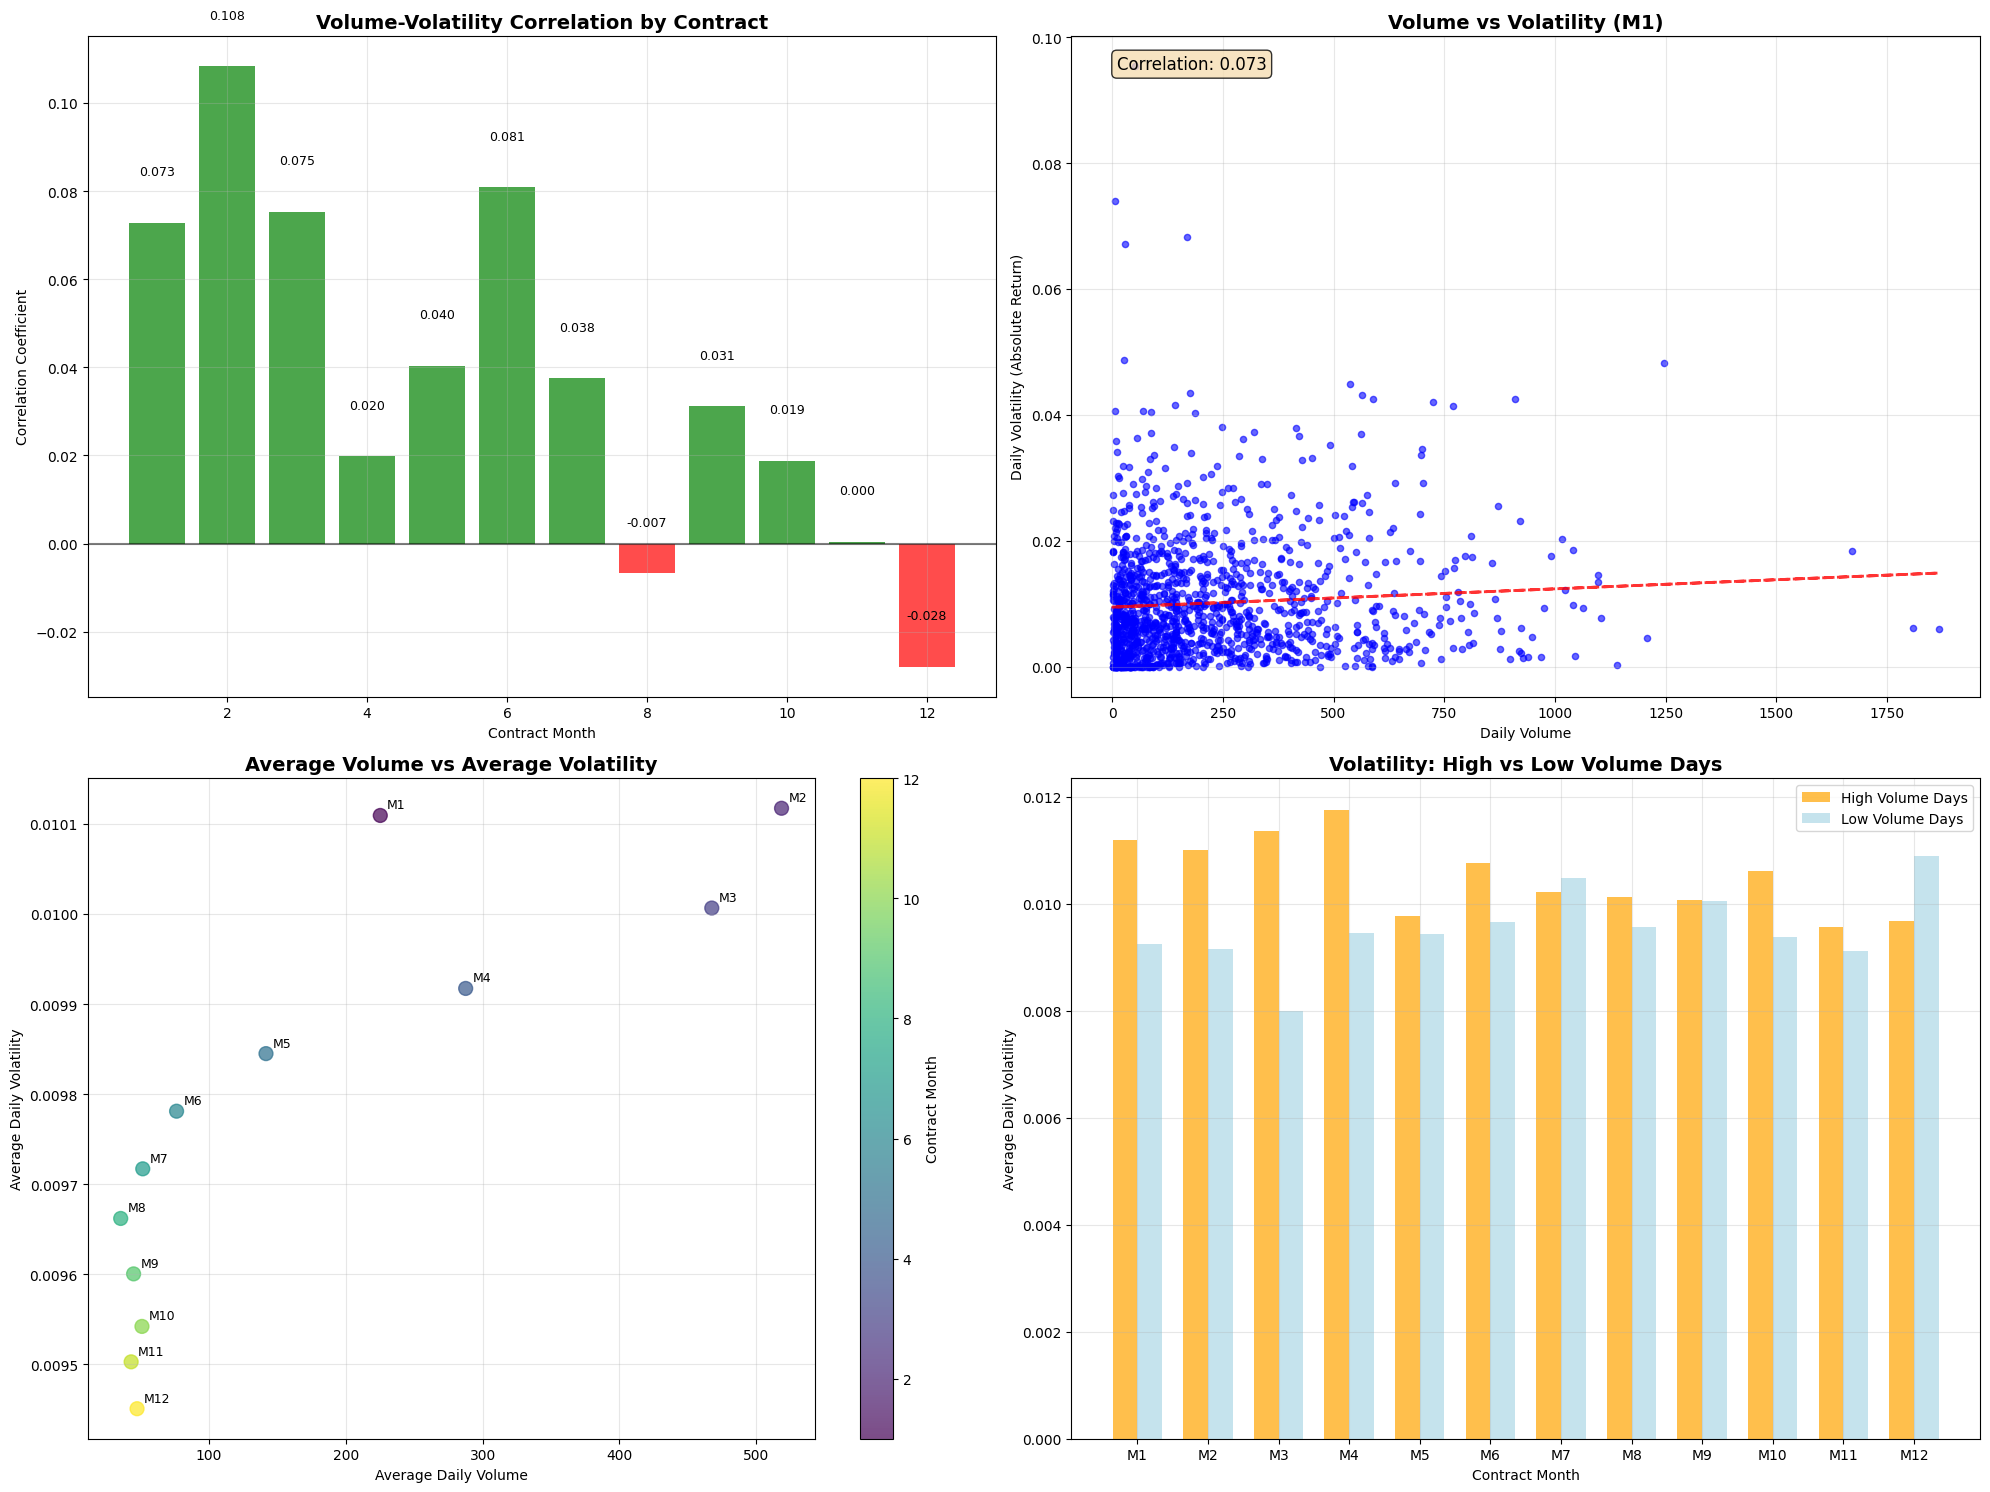

In [8]:
# 出来高-ボラティリティ関係可視化
if vol_volume_analysis:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 相関係数の限月別比較
    contracts = list(vol_volume_analysis.keys())
    correlations = [vol_volume_analysis[c]['correlation'] for c in contracts]
    
    bars1 = ax1.bar(contracts, correlations, 
                   color=['green' if x > 0 else 'red' for x in correlations], alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax1.set_title('Volume-Volatility Correlation by Contract', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Contract Month')
    ax1.set_ylabel('Correlation Coefficient')
    ax1.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar, corr in zip(bars1, correlations):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{corr:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 2. 散布図（近月の例）
    if 1 in vol_volume_analysis:
        sample_data = vol_volume_analysis[1]['data']
        
        ax2.scatter(sample_data['volume'], sample_data['volatility'], 
                   alpha=0.6, s=20, color='blue')
        
        # 回帰線を追加
        z = np.polyfit(sample_data['volume'], sample_data['volatility'], 1)
        p = np.poly1d(z)
        ax2.plot(sample_data['volume'], p(sample_data['volume']), "r--", alpha=0.8, linewidth=2)
        
        corr = vol_volume_analysis[1]['correlation']
        ax2.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=ax2.transAxes, fontsize=12, 
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
        
        ax2.set_title('Volume vs Volatility (M1)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Daily Volume')
        ax2.set_ylabel('Daily Volatility (Absolute Return)')
        ax2.grid(True, alpha=0.3)
    
    # 3. 平均出来高 vs 平均ボラティリティ
    avg_volumes = [vol_volume_analysis[c]['avg_volume'] for c in contracts]
    avg_volatilities = [vol_volume_analysis[c]['avg_volatility'] for c in contracts]
    
    scatter = ax3.scatter(avg_volumes, avg_volatilities, c=contracts, cmap='viridis', s=100, alpha=0.7)
    
    # 契約ラベル追加
    for i, contract in enumerate(contracts):
        ax3.annotate(f'M{contract}', (avg_volumes[i], avg_volatilities[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax3.set_title('Average Volume vs Average Volatility', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Average Daily Volume')
    ax3.set_ylabel('Average Daily Volatility')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Contract Month')
    
    # 4. 高出来高時 vs 低出来高時のボラティリティ比較
    high_vol_vols = [vol_volume_analysis[c]['high_vol_volatility'] for c in contracts]
    low_vol_vols = [vol_volume_analysis[c]['low_vol_volatility'] for c in contracts]
    
    # 有効なデータのみ使用
    valid_data = [(c, h, l) for c, h, l in zip(contracts, high_vol_vols, low_vol_vols) 
                  if not (np.isnan(h) or np.isnan(l))]
    
    if valid_data:
        valid_contracts, valid_high, valid_low = zip(*valid_data)
        
        x_pos = np.arange(len(valid_contracts))
        width = 0.35
        
        bars1 = ax4.bar(x_pos - width/2, valid_high, width, label='High Volume Days', 
                        color='orange', alpha=0.7)
        bars2 = ax4.bar(x_pos + width/2, valid_low, width, label='Low Volume Days', 
                        color='lightblue', alpha=0.7)
        
        ax4.set_title('Volatility: High vs Low Volume Days', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Contract Month')
        ax4.set_ylabel('Average Daily Volatility')
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels([f'M{c}' for c in valid_contracts])
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../generated_images/volume_volatility_relationship.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. 統計サマリーとレポート

### 解釈ガイド:
- **タームストラクチャー効果**: サムエルソン効果の確認
- **流動性ファクター**: 出来高と価格安定性の関係
- **リスク管理**: 限月別リスク特性の理解
- **ポートフォリオ効果**: 限月分散による効果

In [9]:
# 統計サマリーとレポート生成
if vol_metrics is not None:
    print("=" * 80)
    print("LME銅先物ボラティリティ・タームストラクチャー分析レポート")
    print("=" * 80)
    
    # 1. 基本統計
    print(f"\n【1. 基本ボラティリティ統計】")
    print(f"分析対象: {len(vol_metrics)}契約（M1-M{vol_metrics.index.max()}）")
    print(f"最低ボラティリティ: {vol_metrics['annual_vol'].min():.1%} (第{vol_metrics['annual_vol'].idxmin()}限月)")
    print(f"最高ボラティリティ: {vol_metrics['annual_vol'].max():.1%} (第{vol_metrics['annual_vol'].idxmax()}限月)")
    print(f"平均ボラティリティ: {vol_metrics['annual_vol'].mean():.1%}")
    print(f"ボラティリティ標準偏差: {vol_metrics['annual_vol'].std():.1%}")
    
    # 2. タームストラクチャー分析
    print(f"\n【2. タームストラクチャー特性】")
    
    # 前6限月の平均ボラティリティ
    front_6_vol = vol_metrics.loc[vol_metrics.index <= 6, 'annual_vol'].mean() if len(vol_metrics[vol_metrics.index <= 6]) > 0 else np.nan
    back_6_vol = vol_metrics.loc[vol_metrics.index > 6, 'annual_vol'].mean() if len(vol_metrics[vol_metrics.index > 6]) > 0 else np.nan
    
    if not np.isnan(front_6_vol) and not np.isnan(back_6_vol):
        print(f"前6限月平均ボラティリティ: {front_6_vol:.1%}")
        print(f"後期限月平均ボラティリティ: {back_6_vol:.1%}")
        print(f"前後期差: {front_6_vol - back_6_vol:.1%}")
        
        if front_6_vol > back_6_vol:
            print("→ サムエルソン効果確認: 近月ほど高ボラティリティ")
        else:
            print("→ 逆サムエルソン効果: 遠月でより高ボラティリティ")
    
    # 3. リスク調整済みパフォーマンス
    print(f"\n【3. リスク調整済みパフォーマンス】")
    positive_sharpe = vol_metrics[vol_metrics['sharpe_ratio'] > 0]
    if len(positive_sharpe) > 0:
        best_sharpe_contract = vol_metrics['sharpe_ratio'].idxmax()
        best_sharpe_value = vol_metrics.loc[best_sharpe_contract, 'sharpe_ratio']
        print(f"最高シャープレシオ: {best_sharpe_value:.3f} (第{best_sharpe_contract}限月)")
        print(f"正のシャープレシオ契約数: {len(positive_sharpe)}/{len(vol_metrics)}")
    
    # 4. 分布特性
    print(f"\n【4. 分布特性】")
    avg_skewness = vol_metrics['skewness'].mean()
    avg_kurtosis = vol_metrics['kurtosis'].mean()
    print(f"平均歪度: {avg_skewness:.3f} ({'負' if avg_skewness < 0 else '正'}の歪み)")
    print(f"平均尖度: {avg_kurtosis:.3f} ({'厚い' if avg_kurtosis > 0 else '薄い'}尻尾)")
    
    # 5. 出来高-ボラティリティ関係
    if vol_volume_analysis:
        print(f"\n【5. 出来高-ボラティリティ関係】")
        avg_correlation = np.mean([metrics['correlation'] for metrics in vol_volume_analysis.values() 
                                  if not np.isnan(metrics['correlation'])])
        print(f"平均相関係数: {avg_correlation:.3f}")
        
        if avg_correlation > 0.3:
            print("→ 強い正の相関: 高出来高時に高ボラティリティ")
        elif avg_correlation > 0.1:
            print("→ 中程度の正の相関: 出来高とボラティリティに関連性")
        else:
            print("→ 弱い相関: 出来高とボラティリティの関係は限定的")
    
    # 6. トレーディング含意
    print(f"\n【6. トレーディング含意】")
    print("• リスク管理:")
    
    highest_vol_contracts = vol_metrics.nlargest(3, 'annual_vol').index.tolist()
    lowest_vol_contracts = vol_metrics.nsmallest(3, 'annual_vol').index.tolist()
    
    print(f"  - 高リスク契約: {[f'M{c}' for c in highest_vol_contracts]} (慎重なポジションサイジング)")
    print(f"  - 低リスク契約: {[f'M{c}' for c in lowest_vol_contracts]} (安定した取引)")
    
    print("• ポートフォリオ構築:")
    if front_6_vol > back_6_vol:
        print("  - 近月: 高リターン・高リスク特性")
        print("  - 遠月: 安定性重視の長期ポジション")
    
    print("• ヘッジ戦略:")
    print("  - 限月分散によるリスク軽減効果")
    print("  - ボラティリティクラスターに基づくタイミング調整")
    
    print(f"\n{'='*80}")
    print("分析完了: 限月別ボラティリティ特性の包括的理解を提供")
    print(f"{'='*80}")

LME銅先物ボラティリティ・タームストラクチャー分析レポート

【1. 基本ボラティリティ統計】
分析対象: 36契約（M1-M36）
最低ボラティリティ: 18.8% (第34限月)
最高ボラティリティ: 22.0% (第1限月)
平均ボラティリティ: 19.6%
ボラティリティ標準偏差: 0.8%

【2. タームストラクチャー特性】
前6限月平均ボラティリティ: 21.0%
後期限月平均ボラティリティ: 19.4%
前後期差: 1.6%
→ サムエルソン効果確認: 近月ほど高ボラティリティ

【3. リスク調整済みパフォーマンス】
最高シャープレシオ: 0.501 (第33限月)
正のシャープレシオ契約数: 36/36

【4. 分布特性】
平均歪度: -0.239 (負の歪み)
平均尖度: 1.770 (厚い尻尾)

【5. 出来高-ボラティリティ関係】
平均相関係数: 0.038
→ 弱い相関: 出来高とボラティリティの関係は限定的

【6. トレーディング含意】
• リスク管理:
  - 高リスク契約: ['M1', 'M2', 'M3'] (慎重なポジションサイジング)
  - 低リスク契約: ['M34', 'M35', 'M36'] (安定した取引)
• ポートフォリオ構築:
  - 近月: 高リターン・高リスク特性
  - 遠月: 安定性重視の長期ポジション
• ヘッジ戦略:
  - 限月分散によるリスク軽減効果
  - ボラティリティクラスターに基づくタイミング調整

分析完了: 限月別ボラティリティ特性の包括的理解を提供
